# Your First ANN with CuPy and Keras
Toda la data está en https://docs.cupy.dev/en/stable/index.html

In [ ]:

!pip install cupy-cuda100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## imports
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt


In [ ]:
### Checkeo si está la gpu
cp.cuda.Device()

<CUDA Device 0>

# BackPropagation  (Hertz)
Comenzamos notando a los patrones de entrenamiento de entrada y salida de la red como $\{\xi_{k}^{\mu},S_{j}^{\mu}\}$. Considerando una red con $M$ capas y denotamos con el símbolo $V^{m}_{i}$ al "output" de la i-ésima unidad en la capa $m$, con $m = 1,2,...,M $. Tomamos a $V_{i}^{0} = \xi_{i}^{\mu}$. Llamamos a las conecciones entre $V_{j}^{m-1}$ y $V_{i}^{m}$ com $w_{ij}$.

1) Inicializamos los pesos a valores aleatorios chicos.

2) Elegimos un ejemplo $\xi_{k}^{\mu}$ y lo aplicamos como entrada tal que:
$$
V_{k}^{0} = \xi_{k}^{\mu}\quad \text{para todo $k$}
$$
3) Propagamos la señal hacia adelante a través de la red  usando
$$
V_{i}^{m} = g(h_{i}^{m}) = g\left(\sum_{j} w_{ij}^{m}V_{j}^{m-1}\right)
$$
para cada $i$ y $m$ hasta que todas las salidas $V_{i}^{m}$ hayan sido calculadas.

4) Calculamos los deltas de la capa de salida
$$
\delta_{i}^{M} = g'(h_{i}^{M})[S_{i}^{\mu}-V_{i}^{M}]
$$
comparando las salidas $S_{i}^{\mu}$ deseadas y las $V_{i}^{\mu}$ obtenidas para el ejemplo $\mu$ considerado.

5) Calculamos los deltas para las capas anteriores propagando los errores hacia atrás
$$
\delta_{i}^{m-1} = g'(h_{i}^{m-1})\sum_{j} w_{ji}^{m}\delta_{j}^{m}
$$
para $m = M, M-1,...,2$ hasta que el error $\delta$ haya sido calculado para cada unidad.

6) Actualizamos los pesos con
$$
\Delta w_{ij}^{m} = \eta\, \delta_{i}^{m} V_{j}^{m-1}
$$
resultando en pesos nuevos con $\Delta w_{ij}^{new} = w_{ij}^{old} + \Delta w_{ij}$

7) Volver al paso 2 y repetir para $\xi_{k}^{\mu +1}$


![backprop](https://drive.google.com/uc?export=view&id=1AcDTDvgLOOSB6sIuVdwIbym613FJhoII)

In [ ]:
def g(x): ### activation function as tanh
  return cp.tanh(x) #1/(1+cp.exp(-x))

def propFor(ws,V):
  return ws.dot(V)

def backProp(input,output,ws,eta):
  ### Capa 1
  Vs_0 = input
  hs_1 = propFor(ws[0],Vs_0)
  Vs_1 = g(hs_1)

  ### Capa 2
  hs_2 = propFor(ws[1],Vs_1)
  Vs_2 = g(hs_2)


  delta_2 = (1-Vs_2**2) * (output-Vs_2)  ## delta de la capa 2
  delta_1 = (1-Vs_1**2) * (ws[1]*delta_2)  ## delta de la capa 1

  ws[1] += eta*delta_2*Vs_1 ## actualizo la capa 2
  ws[0] += eta*cp.outer(delta_1,Vs_0) ## actualizo la capa 1

  return ws


def NN(input,ws):
  hs_1 = propFor(ws[0],input)
  Vs_1 = g(hs_1)

  hs_2 = propFor(ws[1],Vs_1)
  Vs_out = g(hs_2)
  return Vs_out

def trainingNN(N_epoch,input,output):
  ## Inicializo ws
  ws_0 = cp.random.rand(4,4)
  ws_1 =  cp.random.rand(4)
  ws_in = [ws_0,ws_1]
  ws = ws_in.copy()
  err = cp.zeros(N_epoch)

  for i in range(N_epoch):  ### n epochs
    err_aux = 0

    for x,y in zip(input,output): ### entreno sobre todo el set por cada epoch
      ws = backProp(x,y,ws,0.08)

    for x,y in zip(input,output):   ### evaluo el error de entrenamiento sobre todo el training set
        y_pred = NN(x,ws)
        err_aux += abs(y-NN(x,ws))

    err[i] = err_aux

  err_cpu = cp.asnumpy(err) ### muevo los datos al cpu
  return err_cpu

## Checkeo de Paridad

EL problema que vamos a resolver es el de checkeo de paridad, es decir determinar si tenemos un número par o impar de "1s" en una seria be bits. La arquitectura que vamos a seguir es la de la figura

![NN](https://miro.medium.com/max/441/1*NC5KCQlgpyjXGhuT_2ErmA.jpeg)


## Armo datos

In [ ]:
N = 4
input  = cp.array([[1,1,1,1],[0,0,0,0],[0,1,1,1],[1,1,1,0],[1,1,0,1],[1,0,1,1],
                   [0,0,1,1],[0,1,0,1],[0,1,1,0],[1,0,0,1],[1,0,1,0],[1,1,0,0],
                   [0,0,0,1],[1,0,0,0],[0,1,0,0],[0,0,1,0]])
output = []
for inp in input:
  output.append(abs(sum(inp))%2)
output = cp.array(output)
output

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

## Entreno


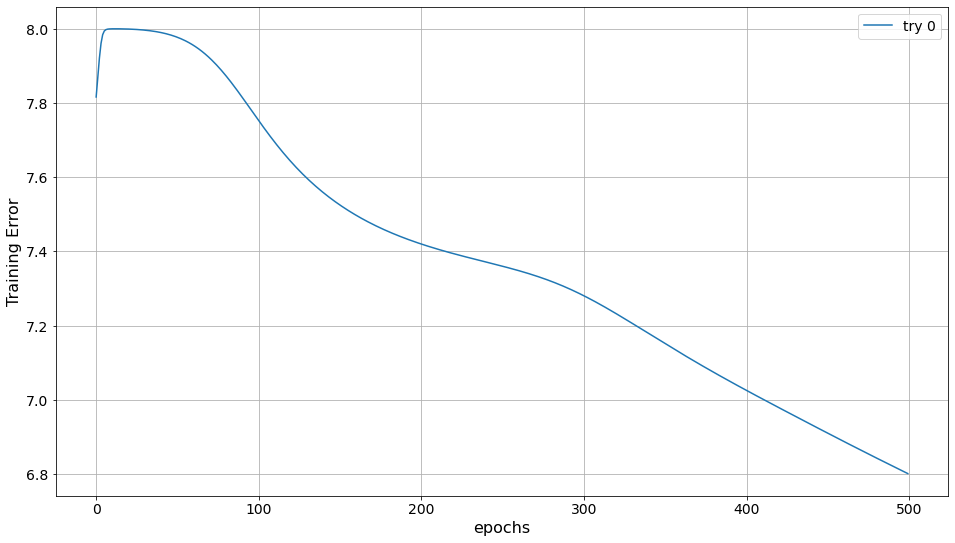

In [ ]:
from matplotlib import pyplot as plt

N_epoch = 500

fig, ax = plt.subplots(figsize = (16,9))
for i in range(1):
  err_cpu = trainingNN(N_epoch,input,output)
  plt.plot(err_cpu,label = "try {}".format(i))
  plt.xlabel("epochs",fontsize= 16)
  plt.ylabel("Training Error",fontsize = 16)
  plt.yticks(fontsize = 14);
  plt.xticks(fontsize = 14);
  plt.legend(fontsize = 14)
  plt.grid()

# Keras

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

input_k  = cp.asnumpy(input)
output_k = cp.asnumpy(output)

model = keras.Sequential([
    layers.Dense(4, activation="tanh",use_bias=False),
    layers.Dense(1, activation="tanh",use_bias=False)
])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

Epoch 1/500
1/1 [==============================] - 0s 280ms/step - loss: 1.2415 - mean_absolute_error: 0.9715
Epoch 2/500
1/1 [==============================] - 0s 9ms/step - loss: 1.2353 - mean_absolute_error: 0.9685
Epoch 3/500
1/1 [==============================] - 0s 9ms/step - loss: 1.2292 - mean_absolute_error: 0.9654
Epoch 4/500
1/1 [==============================] - 0s 9ms/step - loss: 1.2231 - mean_absolute_error: 0.9624
Epoch 5/500
1/1 [==============================] - 0s 8ms/step - loss: 1.2169 - mean_absolute_error: 0.9593
Epoch 6/500
1/1 [==============================] - 0s 8ms/step - loss: 1.2107 - mean_absolute_error: 0.9562
Epoch 7/500
1/1 [==============================] - 0s 7ms/step - loss: 1.2045 - mean_absolute_error: 0.9531
Epoch 8/500
1/1 [==============================] - 0s 10ms/step - loss: 1.1983 - mean_absolute_error: 0.9500
Epoch 9/500
1/1 [==============================] - 0s 10ms/step - loss: 1.1921 - mean_absolute_error: 0.9469
Epoch 10/500
1/1 [======

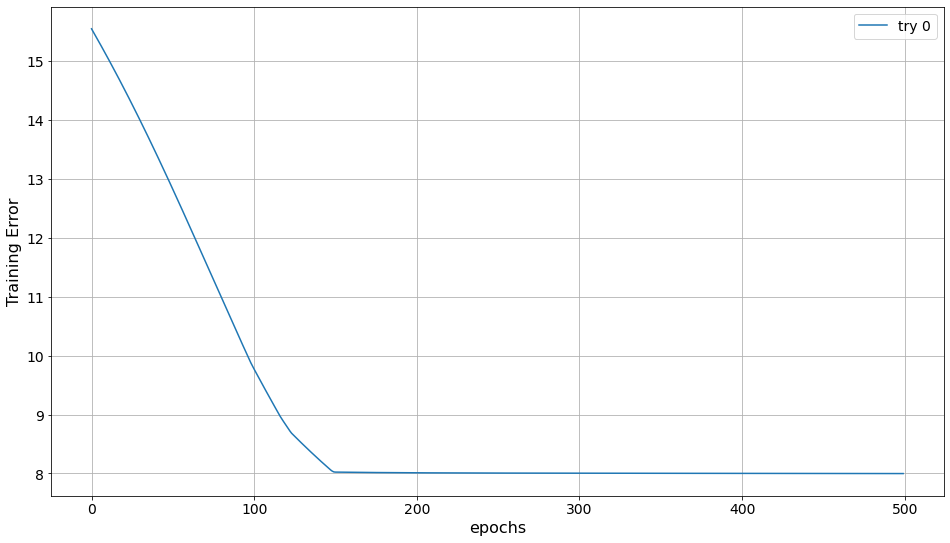

In [ ]:

fig, ax = plt.subplots(figsize = (16,9))
for i in range(1):
  model = keras.Sequential([
    layers.Dense(4, activation="tanh",use_bias=False),
    layers.Dense(1, activation="tanh",use_bias=False)
  ])
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
  output_fit = model.fit(input_k, output_k, epochs=500,)

  plt.plot(np.array(output_fit.history["mean_absolute_error"])*16,label = "try {}".format(i))
  plt.xlabel("epochs",fontsize= 16)
  plt.ylabel("Training Error",fontsize = 16)
  plt.yticks(fontsize = 14);
  plt.xticks(fontsize = 14);
  plt.legend(fontsize = 14)
  plt.grid()

In [ ]:
pred_k = model.predict(input_k)
#print(pred_k.ravel())
print(sum(abs(output_k-pred_k.ravel())))

1.3408951392630115
